In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.fft import rfft, irfft, rfftfreq

C:\Users\richa\AppData\Local\Temp\ipykernel_56796\905663056.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
input_pos = input("Enter Position: ")
input_deg = input("Enter Angle: ")

### Laden der Daten anhand der gegebenen Position und Messwinkel

In [4]:
def find_matching_files(file_list, angle, position):
    for file in file_list:
        if f"angle_{angle}" in file and f"pos_{position}" in file:
            matching_file = os.path.join(folder_path, file)
            filename = file
      
            
    return (matching_file, filename)


folder_path = os.path.join(os.getcwd(), 'Logs')
files = os.listdir(folder_path)
file = find_matching_files(files, input_deg, input_pos)
scan_df = pd.read_csv(file[0])
data_df = scan_df.iloc[:, :-3]

In [5]:
#data_df[data_df['shape'] == 'pentagon'].to_csv('data_test_pentagon_2.csv', index=False)

In [6]:
file

('c:\\Users\\richa\\Documents\\PyESP\\Logs\\scans_angle_2_8125_pos_5_rot_1.csv',
 'scans_angle_2_8125_pos_5_rot_1.csv')

In [7]:
data_df

,0.0,2.8125,5.625,8.4375,11.25,14.0625,16.875,19.6875,22.5,25.3125,...,334.6875,337.5,340.3125,343.125,345.9375,348.75,351.5625,354.375,357.1875,shape
0,89.0,92.0,92.0,96.0,96.0,99.0,120.0,159.0,172.0,172.0,...,145.0,159.0,159.0,99.0,99.0,96.0,96.0,92.0,92.0,pentagon
1,92.0,92.0,96.0,96.0,99.0,120.0,159.0,159.0,172.0,159.0,...,159.0,159.0,99.0,99.0,96.0,96.0,92.0,92.0,89.0,pentagon
2,92.0,96.0,96.0,99.0,120.0,159.0,172.0,172.0,159.0,159.0,...,159.0,99.0,99.0,96.0,96.0,92.0,92.0,89.0,92.0,pentagon
3,96.0,96.0,99.0,120.0,159.0,172.0,172.0,159.0,159.0,169.0,...,99.0,99.0,96.0,96.0,92.0,92.0,89.0,92.0,92.0,pentagon
4,96.0,99.0,120.0,159.0,171.0,172.0,155.0,159.0,168.0,159.0,...,99.0,96.0,96.0,92.0,92.0,89.0,92.0,92.0,96.0,pentagon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,81.0,79.0,79.0,79.0,78.0,79.0,79.0,79.0,82.0,103.0,...,96.0,96.0,442.0,518.0,99.0,96.0,79.0,106.0,103.0,cube
960,79.0,79.0,79.0,79.0,79.0,79.0,79.0,82.0,103.0,110.0,...,96.0,443.0,509.0,99.0,96.0,79.0,106.0,103.0,82.0,cube
961,79.0,79.0,79.0,79.0,79.0,79.0,82.0,103.0,110.0,96.0,...,443.0,506.0,99.0,96.0,79.0,106.0,103.0,82.0,79.0,cube
962,79.0,79.0,79.0,79.0,79.0,82.0,103.0,110.0,96.0,96.0,...,505.0,99.0,96.0,79.0,106.0,103.0,82.0,79.0,79.0,cube


### Helferfunktion, die den String-Header in einen Numpy-Array mit float-Werten umwandelt


In [8]:
def header_to_int(df: pd.DataFrame):
    columns = df.iloc[:, :-1].columns.values
    columns_int = np.array([float(column) for column in columns])
    return columns_int

### Helferfunktion, die anhand der Messwerte des Zylinders, der indirekt als Kalibrierungsobjekt dient, den Abstand eines jeden Messpunktes zum Mittelpunkt der Messplatte berechnet

In [9]:
def get_dist_middlepoint(df: pd.DataFrame):
    diameter_cylinder = 50
    grouped = df.groupby('shape').mean()
    distance_to_middle = grouped.loc['cylinder', :].values.mean() + diameter_cylinder/2
    distance_object_middle_to_edge = distance_to_middle - grouped.loc['cylinder', :].values
    print(distance_to_middle)
    return distance_object_middle_to_edge

dist = get_dist_middlepoint(data_df)   

113.41881535171103


### Helferfunktion, die den maximal möglichen Messwert berechnet

In [10]:
def get_max_possible_dist(df: pd.DataFrame):
    diameter_cylinder = 50
    cylinder_measurement = df.groupby('shape').mean().loc['cylinder', :].values.mean()

    return diameter_cylinder/2 + cylinder_measurement

max_dist = get_max_possible_dist(data_df)

In [11]:
max_dist

113.41881535171103

## Bereinigen der Messdaten
Das Bereinigen der Messdaten beginnt mit dem Ersetzen aller Werte, die den Maximalwert überschreiten mit NaN

In [12]:
def normalize_minus_one_to_one(array):
    return 2 * ((array - np.min(array)) / (np.max(array) - np.min(array))) - 1

In [13]:
def fft_filter(row, cutoff=0.07):
    # FFT der Zeile
    fft_coeffs = rfft(row)
    fft_freqs = rfftfreq(len(row))
    
    # Filter: Entfernen hochfrequenter Komponenten
    low_pass_filter = fft_freqs < cutoff
    filtered_fft_coeffs = fft_coeffs * low_pass_filter
    
    # Rücktransformation in den Zeitbereich
    filtered_row = irfft(filtered_fft_coeffs)
    return filtered_row

In [14]:
values_df = data_df.iloc[:, :-1]

In [15]:
median_window_size = 11 if input_deg == '2' else 3


data_filtered_df = pd.DataFrame()
data_filter = pd.DataFrame()
for i in range(len(data_df)):
    data_filtered = medfilt(values_df.iloc[i], kernel_size=median_window_size)
    data_filtered_fft_int = fft_filter(data_filtered)
    data_filtered_df= pd.concat([data_filtered_df, pd.DataFrame(data_filtered_fft_int).T], axis=0, ignore_index=True)
    data_filter = pd.concat([data_filter, pd.DataFrame(data_filtered).T], axis=0, ignore_index=True)
    


data_filtered_df.columns = data_df.columns[:-1]
data_filter.columns = data_df.columns[:-1]

data_filtered_df_diff = data_filtered_df.diff(axis=1)
data_filtered_df_diff = data_filtered_df_diff.apply(lambda x: normalize_minus_one_to_one(x), axis=1)
data_filtered_df_diff = data_filtered_df_diff.apply(lambda x: x-np.mean(x), axis=1)
data_filtered_df_diff.fillna(0, inplace=True)
data_filtered_df['shape'] = data_df['shape']
data_filtered_df_diff['shape'] = data_df['shape']
data_filter['shape'] = data_df['shape']


<Axes: >

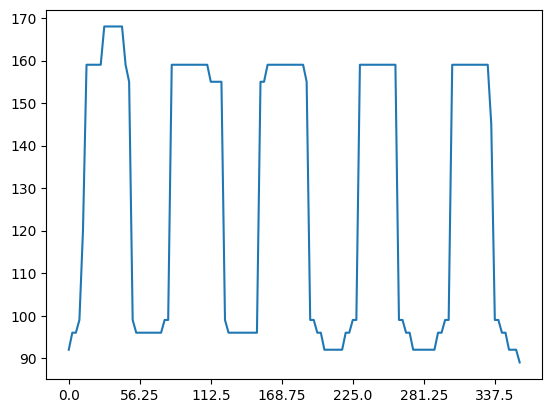

In [16]:
data_filter[data_filter['shape'] == 'pentagon'].iloc[2,:-1].plot()

In [17]:
file[1].replace('.csv', '')

'scans_angle_2_8125_pos_5_rot_1'

In [18]:
# data_filtered_df.to_csv(f"Filtered_Data\\{file[1].replace('.csv', '')}_filtered.csv", index=False)

In [19]:
# data_filtered_df_diff.to_csv(f"Normalized_Data\\{file[1].replace('.csv', '')}_normalized.csv", index=False)

<Axes: >

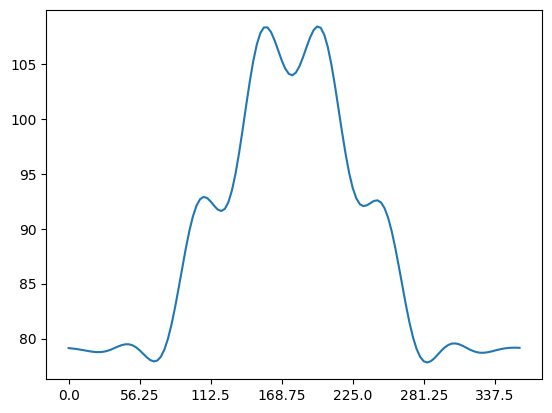

In [30]:
data_filtered_df[data_filtered_df['shape'] == 'cylinder'].iloc[100,:-1].plot()

<Axes: >

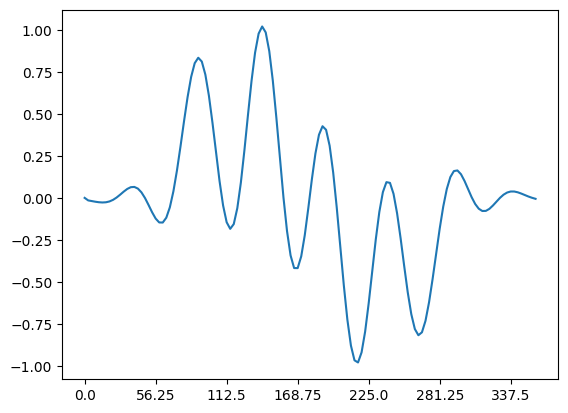

In [31]:
data_filtered_df_diff[data_filtered_df_diff['shape'] == 'cylinder'].iloc[100,:-1].plot()

In [22]:
# angles = np.array([float(angle) for angle in data_df.columns[:-1]])

# target_angles = np.linspace(0, 360, 512, endpoint=False)

# df_interpolated = pd.DataFrame()

# for index, row in data_df.iterrows():
#     values = row[:-1].values
    
#     interpolation_function = interp1d(angles, values, kind='linear', fill_value="extrapolate")
    
#     interpolated_values = interpolation_function(target_angles)
    
#     df_interpolated = pd.concat([df_interpolated, pd.DataFrame(interpolated_values).T], axis=0, ignore_index=True)
#     #df_interpolated.append(pd.Series(interpolated_values), ignore_index=True)

# df_interpolated['shape'] = data_df['shape']

# new_columns = [f"{angle:.3f}" for angle in target_angles] + ['shape']
# df_interpolated.columns = new_columns


In [23]:
# df_interpolated

In [24]:
# for column in data_df.columns:
#     if column != 'shape':
#         data_df[column] = data_df[column].apply(lambda x: x if x <= max_dist else np.nan)


In [25]:
# data_df[data_df['shape'] == 'prisma'].iloc[20,:-1].plot()

## Plot der Ergebnisse in einem Polarplot

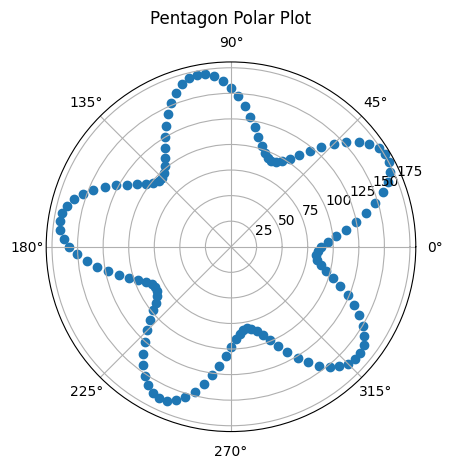

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(header_to_int(data_df)*np.pi / 180, data_filtered_df[data_filtered_df['shape'] == 'pentagon'].iloc[2,:-1].values)
#ax.set_rmax(150)
#ax.set_rscale('log')  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_title("Pentagon Polar Plot", va='bottom')
plt.show()

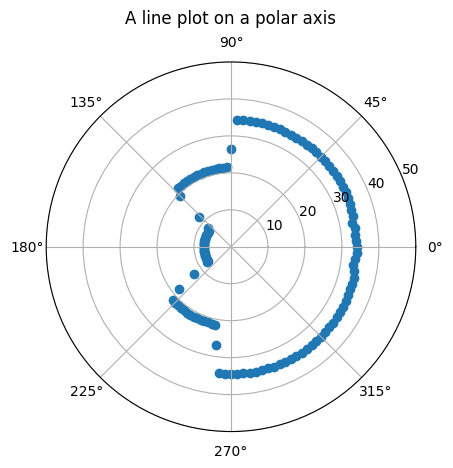

In [27]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(header_to_int(data_df)*np.pi / 180, dist)
ax.set_rmax(50)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()